# Activity

In [262]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from copy import deepcopy as dc
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn

In [263]:
netflix_data = pd.read_csv('NFLX.csv', sep=',')

netflix_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000
1,2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800
2,2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400
3,2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800
4,2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200


Let's find out more information about the dataset.

In [264]:
netflix_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4581 entries, 0 to 4580
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4581 non-null   object 
 1   Open       4581 non-null   float64
 2   High       4581 non-null   float64
 3   Low        4581 non-null   float64
 4   Close      4581 non-null   float64
 5   Adj Close  4581 non-null   float64
 6   Volume     4581 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 250.6+ KB


As we can see there are no missing values in the dataset. The dataset has 7 columns.
Attributes:
- Date: Date of the observation
- Open: Opening price of the stock
- High: Highest price of the stock
- Low: Lowest price of the stock
- Close: Closing price of the stock
- Adj Close: Adjusted closing price of the stock
- Volume: Volume of the stock traded

All of the attributes are numerical, only the date is a object.

In [265]:
netflix_data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,4581.000000,4581.000000,4581.000000,4581.000000,4581.000000,4.581000e+03
mean,78.031471,79.285690,76.736079,78.072056,78.072056,1.760516e+07
std,118.372084,120.276839,116.376768,118.435303,118.435303,1.971130e+07
min,0.377857,0.410714,0.346429,0.372857,0.372857,2.856000e+05
25%,3.778571,3.857143,3.685714,3.784286,3.784286,6.908900e+06
50%,15.392858,15.671429,14.970000,15.324286,15.324286,1.155350e+07
75%,97.830002,99.529999,96.760002,97.889999,97.889999,2.113440e+07
max,567.979980,575.369995,520.960022,548.729980,548.729980,3.234140e+08


We can see that the data is from 2002 to 2022 year.

In [266]:
netflix_data.nunique()

,0
Date,4581
Open,4058
High,4036
Low,4021
Close,4120
Adj Close,4120
Volume,4452


In [267]:
netflix_data.shape[0] - netflix_data.drop_duplicates().shape[0]

0

The are no duplicate rows in the dataset.

Let's convert Date object to the same date format.

In [268]:
netflix_data['Date'] = pd.to_datetime(netflix_data['Date'])
netflix_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4581 entries, 0 to 4580
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       4581 non-null   datetime64[ns]
 1   Open       4581 non-null   float64       
 2   High       4581 non-null   float64       
 3   Low        4581 non-null   float64       
 4   Close      4581 non-null   float64       
 5   Adj Close  4581 non-null   float64       
 6   Volume     4581 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 250.6 KB


#### Data distribution

array([[<Axes: title={'center': 'Date'}>,
        <Axes: title={'center': 'Open'}>,
        <Axes: title={'center': 'High'}>],
       [<Axes: title={'center': 'Low'}>,
        <Axes: title={'center': 'Close'}>,
        <Axes: title={'center': 'Adj Close'}>],
       [<Axes: title={'center': 'Volume'}>, <Axes: >, <Axes: >]],
      dtype=object)

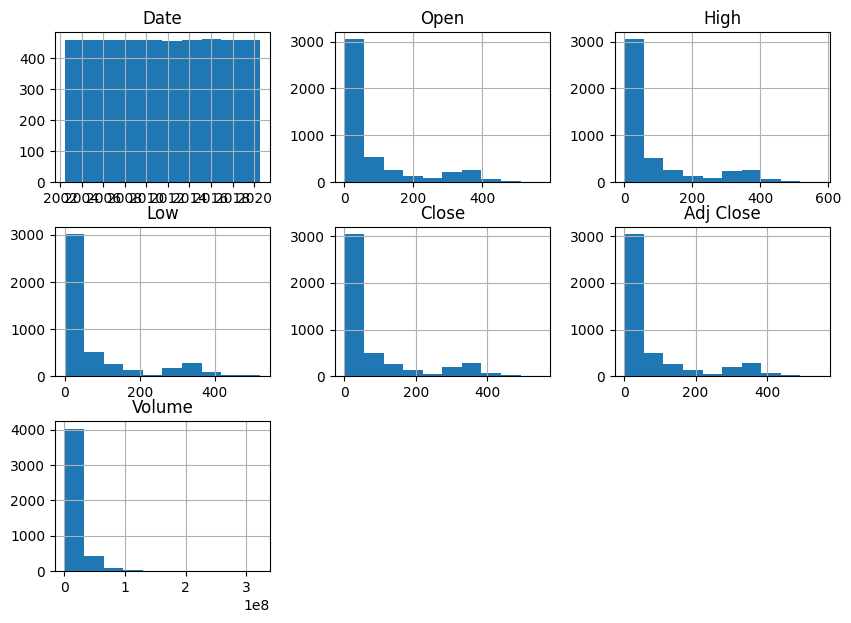

In [269]:
netflix_data.hist(figsize=(10,7))

#### Correlation matrix


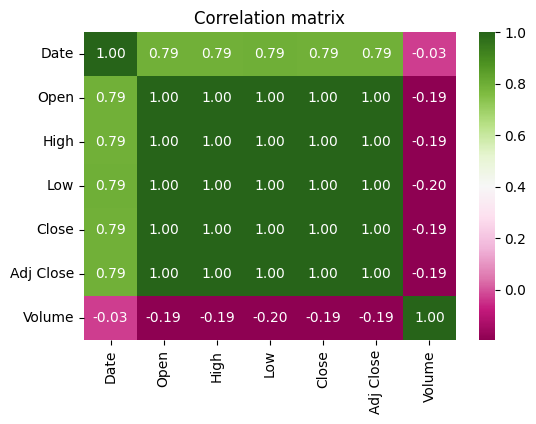

In [270]:
netflix_data_corr = netflix_data.corr()
plt.figure(figsize=(6, 4))
sns.heatmap(netflix_data_corr, fmt='.2f', annot=True, cmap='PiYG')
plt.title('Correlation matrix')
plt.show()

Volume has the least correlation with other attributes but in our opinion it still matter, becase the correlation between Volume and stock prices is 0.19 in average, and it is not so low. There are also correlation 1 between Open, High, Low, Close and Adj Close prices. It is obvious that they are highly correlated, because they are the same stock prices, but in different time of the day.

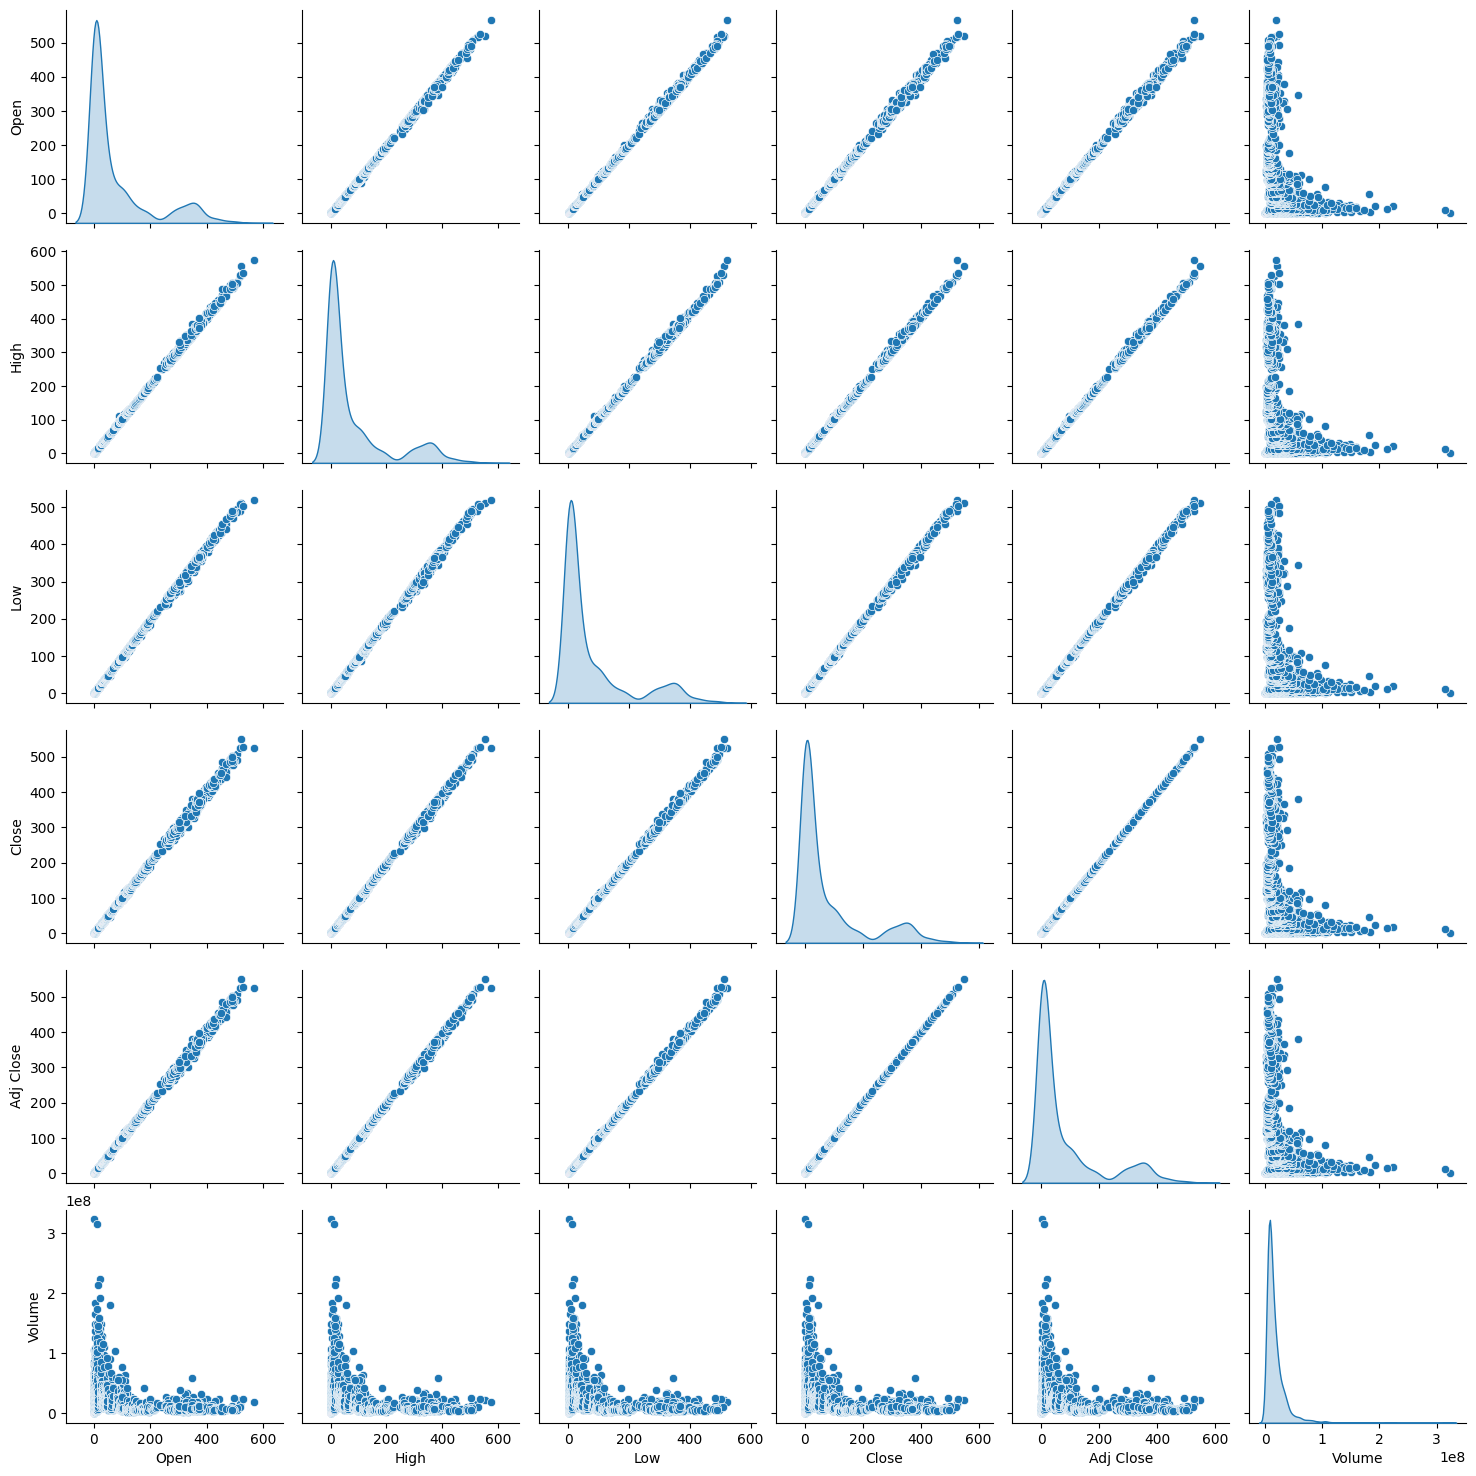

In [271]:
sns.pairplot(netflix_data, diag_kind='kde')

popis laaalalal

### Distribution of the stock prices by years

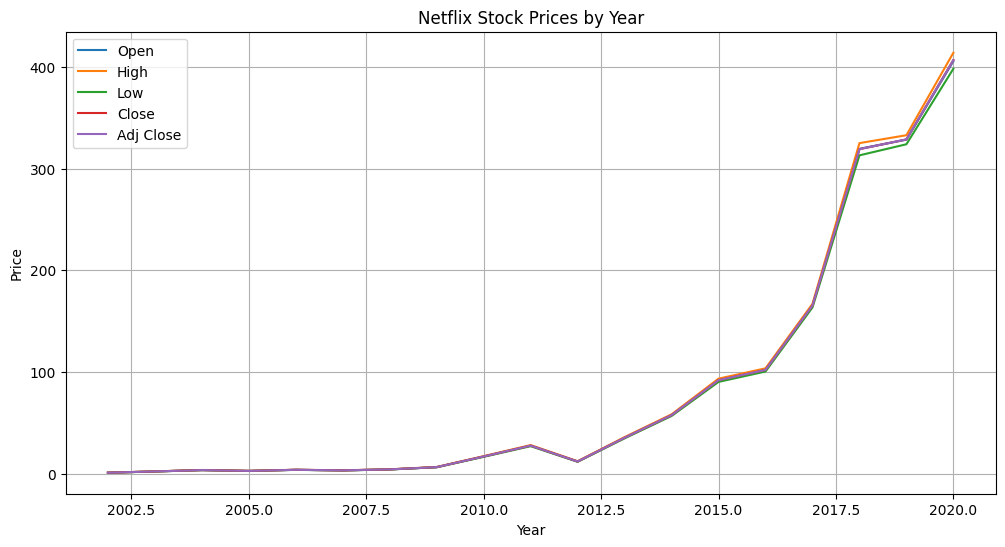

In [272]:
netflix_data['Year'] = netflix_data['Date'].dt.year

yearly_data = netflix_data.groupby('Year').mean()
plt.figure(figsize=(12, 6))
for column in ["Open", "High", "Low", "Close", "Adj Close"]:
    plt.plot(yearly_data.index, yearly_data[column], label=column)

plt.title('Netflix Stock Prices by Year')
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()


As we can see the stock prices are increasing over the years. It started to significantly increase after 2010 year. The stock prices are pretty simmilar between open, high, low and close prices. We can say that trend is increasing here. And there no seasonality in the stock prices.

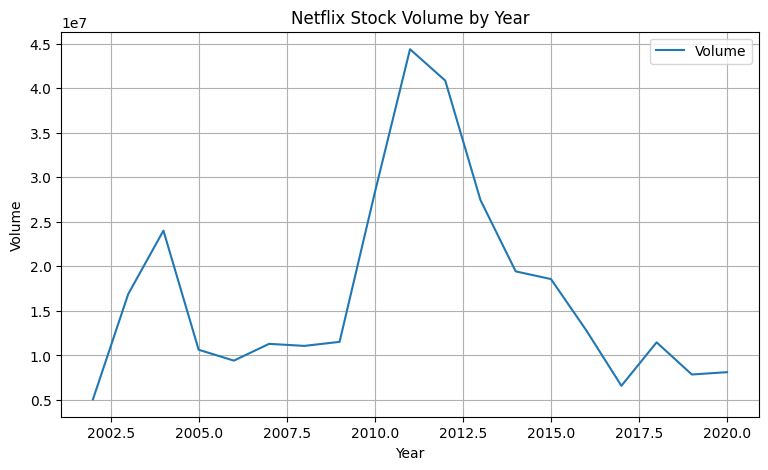

In [273]:
plt.figure(figsize=(9, 5))
for column in ["Volume"]:
    plt.plot(yearly_data.index, yearly_data[column], label=column)

plt.title('Netflix Stock Volume by Year')
plt.xlabel('Year')
plt.ylabel('Volume')
plt.legend()
plt.grid()
plt.show()


From the plot above we can see that the highest volume was traded between year 2010 and 2012. After that the volume of the stock traded is decreasing.

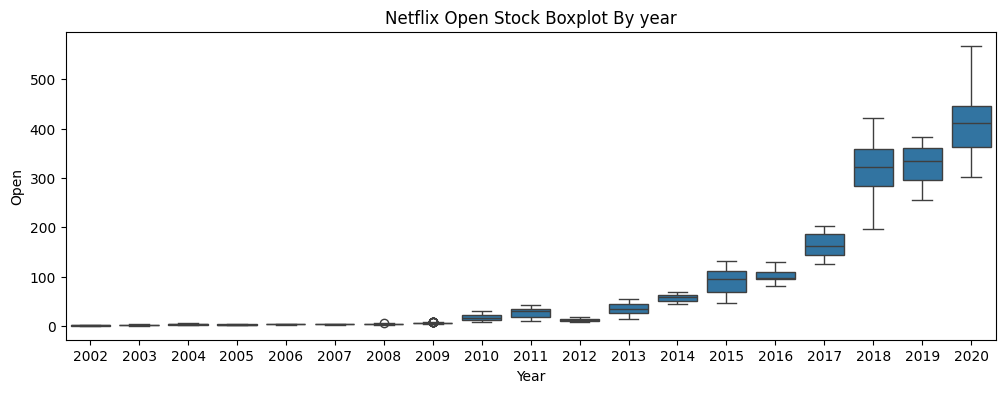

In [274]:
_, ax = plt.subplots(figsize=(12,4))
sns.boxplot(x=netflix_data['Year'], y=netflix_data['Open'], ax=ax)
plt.title('Netflix Open Stock Boxplot By year')
plt.show()

netflix_data = netflix_data.drop(columns=['Year'])

#### Outliers
We deside not to remove outliers, because they are nearly 10% of the all data and also they represent important real-world events that your model should learn from and not just noises or errors in the data.


### Stationarity of the data
Stationarity is a property of a time series. A stationary series is one where the values of the series is not a function of time. So, the values are independent of time.
Let's check the stationarity of the data.

In [275]:

adf_result = adfuller(netflix_data['Volume'])

print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"   {key}: {value}")

# Interpretation
if adf_result[1] <= 0.05:
    print("The time series is stationary (reject null hypothesis).")
else:
    print("The time series is non-stationary (fail to reject null hypothesis).")

ADF Statistic: -4.780262128254479
p-value: 5.931685508701304e-05
Critical Values:
   1%: -3.4317883367510076
   5%: -2.862175575442719
   10%: -2.5671083199600684
The time series is stationary (reject null hypothesis).


We can see from the test that for attribute Volume the p-value is less than 0.05, so we can reject the null hypothesis and say that the data is stationary.

In [276]:
adf_result = adfuller(netflix_data['Open'])

print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"   {key}: {value}")

# Interpretation
if adf_result[1] <= 0.05:
    print("The time series is stationary (reject null hypothesis).")
else:
    print("The time series is non-stationary (fail to reject null hypothesis).")

ADF Statistic: 2.1260797764442545
p-value: 0.998815959771424
Critical Values:
   1%: -3.431788653186758
   5%: -2.862175715236243
   10%: -2.5671083943786552
The time series is non-stationary (fail to reject null hypothesis).


As we can see based on plots above and this ADF test - the data is not stationary. The p-value is 0.99, which is higher than 0.05, so we can't reject the null hypothesis. Also above the test was made for Open attribute, but the results are similar for other price attributes. But in here we don't need to have stationary data for stock forecasting, because the stock prices are not stationary in real world.

As the distribution of all of the stock prices are really simmilar and in stock market the most important is Close attribute, so we will continue only with it. Let's split data into train and test data.

In [277]:
netflix_data = netflix_data[['Date', 'Close']]

train_data, test_data = train_test_split(netflix_data, test_size=0.15, shuffle=False)

We dont use shuffle here because we are working with time series data and we need to keep the order of the data.

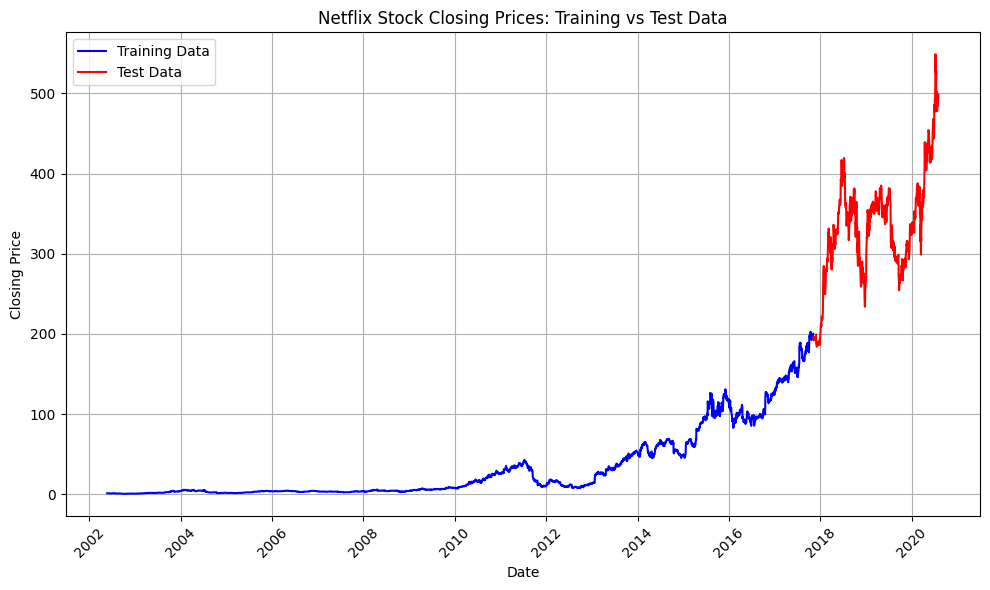

In [278]:
plt.figure(figsize=(10, 6))
plt.plot(train_data['Date'], train_data['Close'], label='Training Data', color='blue')
plt.plot(test_data['Date'], test_data['Close'], label='Test Data', color='red')

plt.title('Netflix Stock Closing Prices: Training vs Test Data')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Lets prepare the data for the time series forecasting. We will use the last 7 days to predict the next day Close price.

In [279]:
def prepare_data(df, n_steps):
    df = dc(df)

    df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 7
train_data = prepare_data(train_data, lookback)
train_data.head()

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2002-06-04,1.117857,1.128571,1.076429,1.071429,1.103571,1.157143,1.210000,1.196429
2002-06-05,1.147143,1.117857,1.128571,1.076429,1.071429,1.103571,1.157143,1.210000
2002-06-06,1.182143,1.147143,1.117857,1.128571,1.076429,1.071429,1.103571,1.157143
2002-06-07,1.118571,1.182143,1.147143,1.117857,1.128571,1.076429,1.071429,1.103571
2002-06-10,1.156429,1.118571,1.182143,1.147143,1.117857,1.128571,1.076429,1.071429


In [280]:
test_data = prepare_data(test_data, lookback)
test_data.head()

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2017-11-16,195.509995,192.119995,195.710007,195.080002,192.020004,193.899994,196.440002,195.889999
2017-11-17,193.199997,195.509995,192.119995,195.710007,195.080002,192.020004,193.899994,196.440002
2017-11-20,194.100006,193.199997,195.509995,192.119995,195.710007,195.080002,192.020004,193.899994
2017-11-21,196.229996,194.100006,193.199997,195.509995,192.119995,195.710007,195.080002,192.020004
2017-11-22,196.320007,196.229996,194.100006,193.199997,195.509995,192.119995,195.710007,195.080002


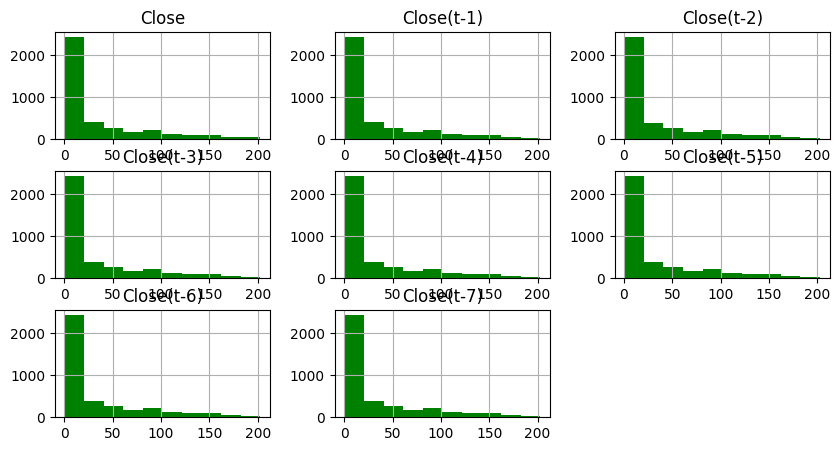

In [281]:
train_data.hist(figsize=(10, 5), color='green')
plt.show()

array([[<Axes: title={'center': 'Close'}>,
        <Axes: title={'center': 'Close(t-1)'}>,
        <Axes: title={'center': 'Close(t-2)'}>],
       [<Axes: title={'center': 'Close(t-3)'}>,
        <Axes: title={'center': 'Close(t-4)'}>,
        <Axes: title={'center': 'Close(t-5)'}>],
       [<Axes: title={'center': 'Close(t-6)'}>,
        <Axes: title={'center': 'Close(t-7)'}>, <Axes: >]], dtype=object)

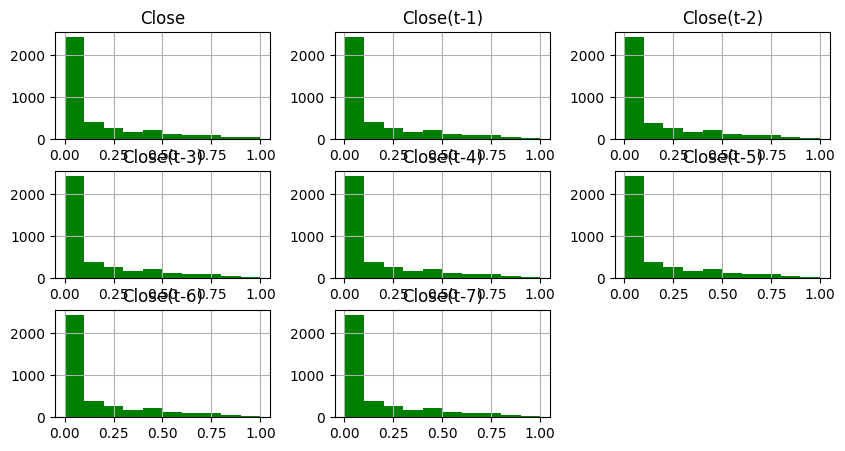

In [282]:
scaler = MinMaxScaler()
scaler.fit(train_data)

train_data_scaled = scaler.transform(train_data)
test_data_scaled = scaler.transform(test_data)

train_data = pd.DataFrame(train_data_scaled, columns=train_data.columns, index=train_data.index)
test_data = pd.DataFrame(test_data_scaled, columns=test_data.columns, index=test_data.index)

train_data.hist(figsize=(10, 5), color='green')

## Forecasting models

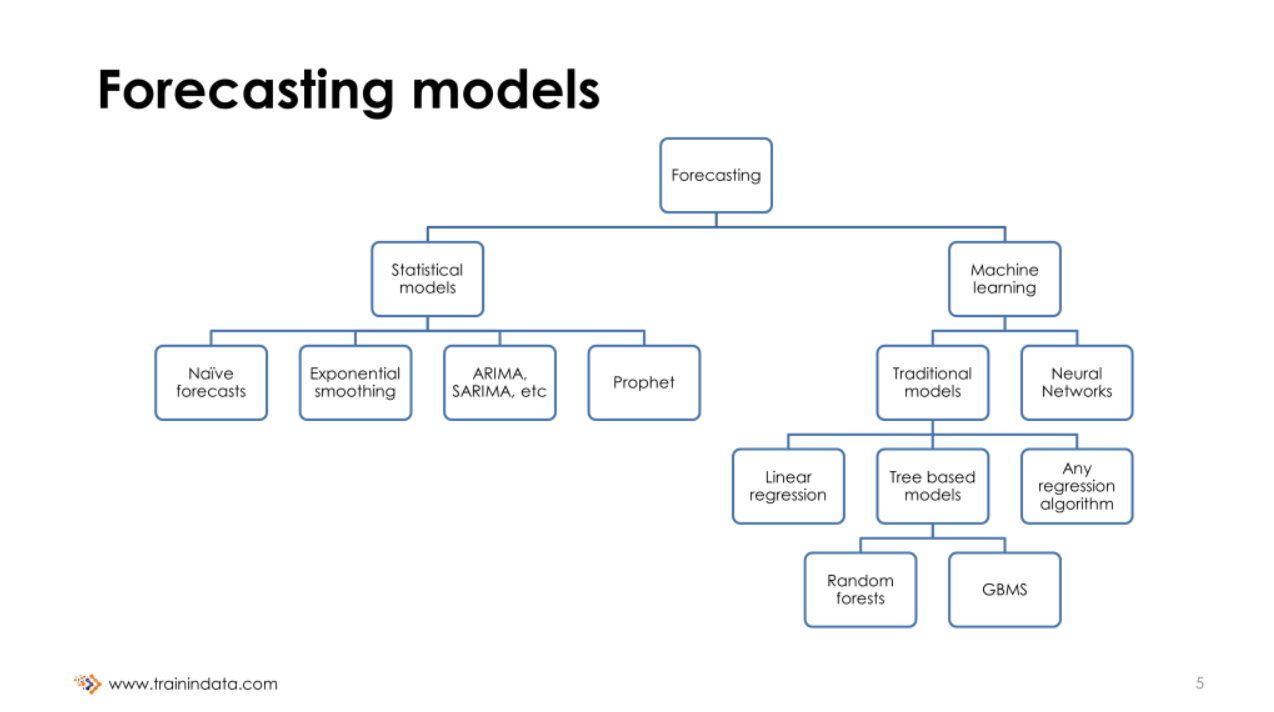

This is the graph of the existing forecasting models. We will focus on the right side of the graph, because we are going to use the machine learning models.

## Modeling

In [283]:
X_train, y_train = train_data.drop(columns='Close'), train_data['Close']
X_test, y_test = test_data.drop(columns='Close'), test_data['Close']

### Helper functions

In [284]:
# function to plot predictions vs actual values
def plot_predictions(y_test, predictions, model_name):
    plt.figure(figsize=(16, 6))
    plt.plot(y_test.index, y_test, label='Actual', color='blue')
    plt.plot(y_test.index, predictions, label='Predicted', color='red', linestyle='--')
    plt.title(f'{model_name} on Test Data: Predicted vs Actual')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid()
    plt.show()

# function to evaluate models
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"R^2 Score: {r2:.4f}")
    return mse, mae, r2

### Linear Regression

Linear Regression Evaluation:
Mean Squared Error: 0.0020
Mean Absolute Error: 0.0322
R^2 Score: 0.9806


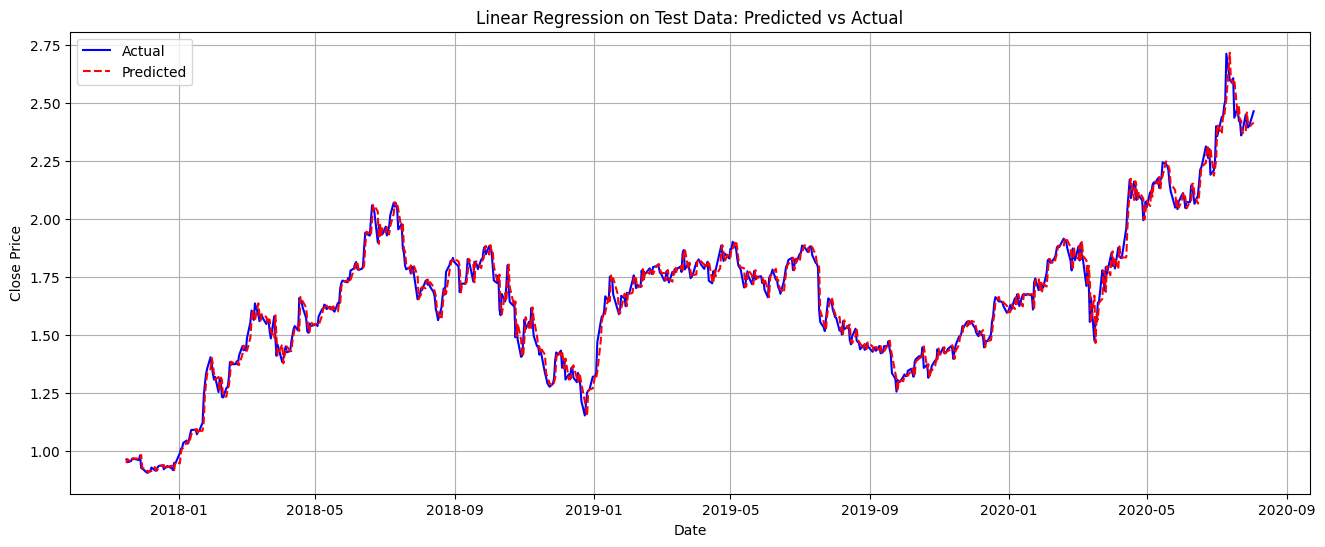

In [285]:
model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print("Linear Regression Evaluation:")
evaluate_model(y_test, predictions)
plot_predictions(y_test, predictions, "Linear Regression")

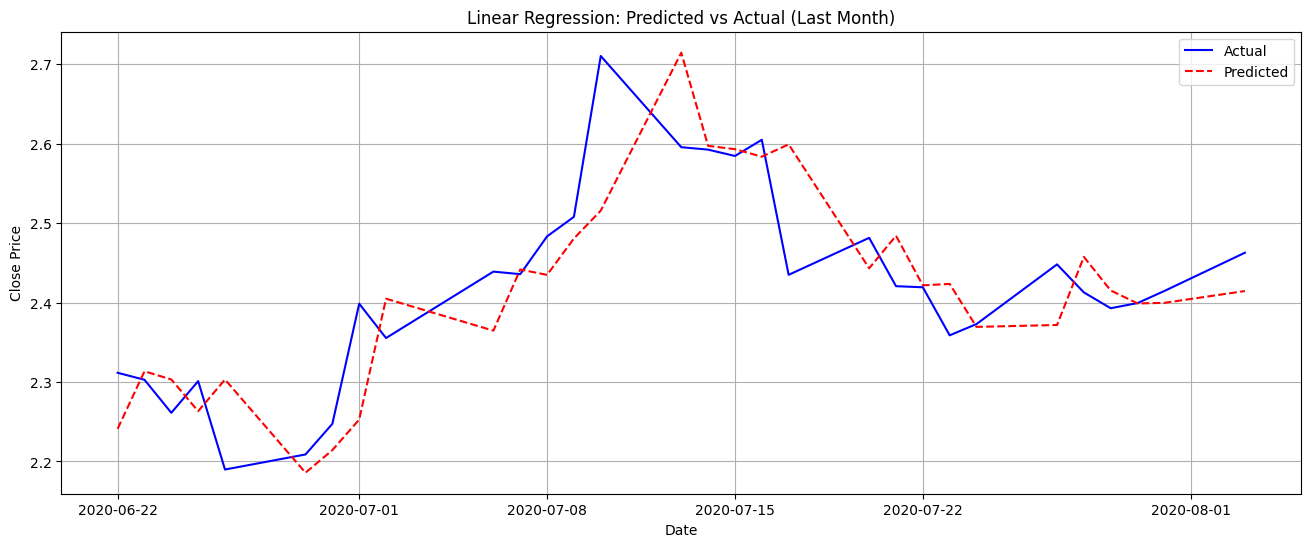

In [286]:
# Plot for the last month
last_month = y_test.index[-30:]
plt.figure(figsize=(16, 6))
plt.plot(last_month, y_test[-30:], label='Actual', color='blue')
plt.plot(last_month, predictions[-30:], label='Predicted', color='red', linestyle='--')
plt.title('Linear Regression: Predicted vs Actual (Last Month)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid()
plt.show()

### Random Forest


Random Forest Evaluation:
Mean Squared Error: 0.5623
Mean Absolute Error: 0.6815
R^2 Score: -4.5329


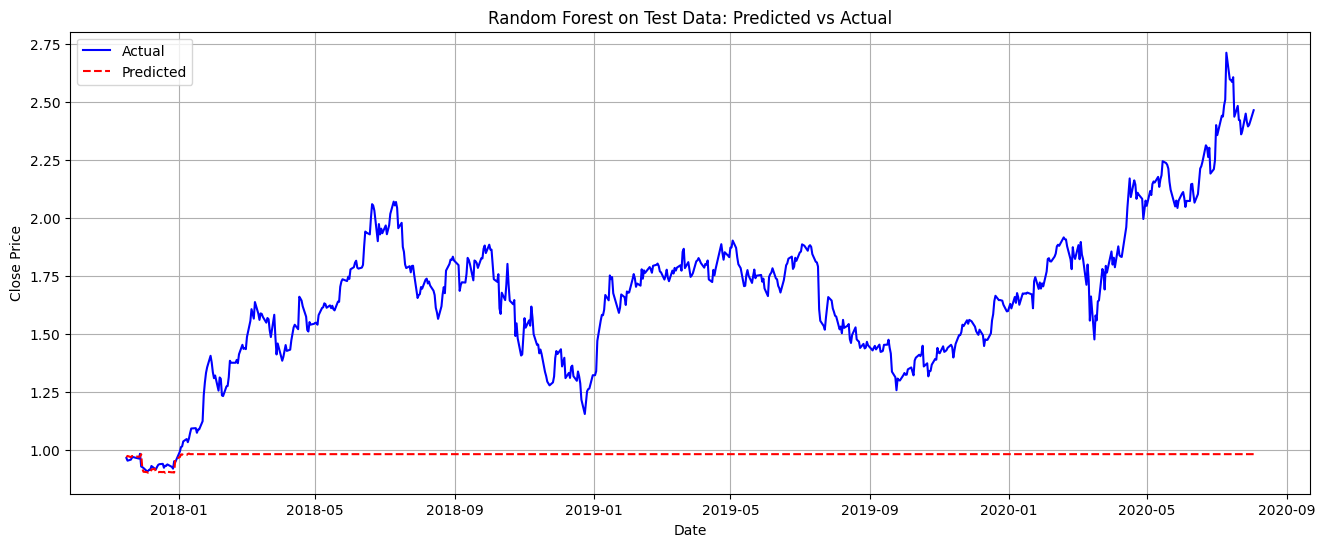

In [287]:
def random_forest_model(X_train, y_train, X_test, y_test):
    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    print("\nRandom Forest Evaluation:")
    evaluate_model(y_test, predictions)
    plot_predictions(y_test, predictions, "Random Forest")

# Apply models
random_forest_model(X_train, y_train, X_test, y_test)

### XGBoost


XGBoost Evaluation:
Mean Squared Error: 0.5660
Mean Absolute Error: 0.6850
R^2 Score: -4.5693


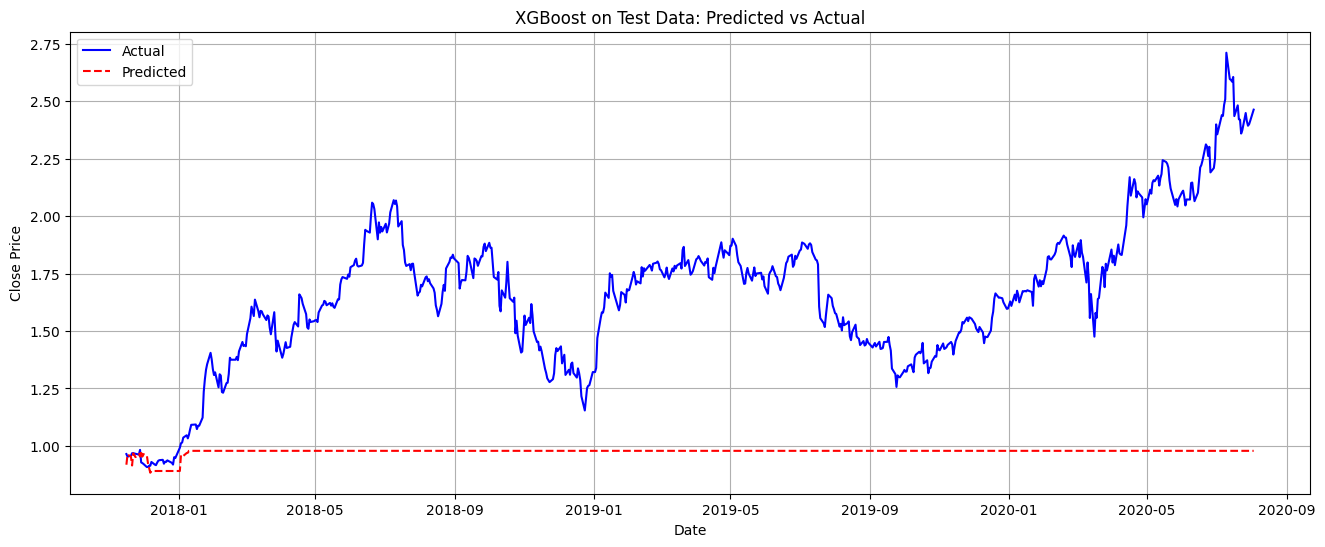

In [288]:
def xgboost_model(X_train, y_train, X_test, y_test):
    model = xgb.XGBRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    print("\nXGBoost Evaluation:")
    evaluate_model(y_test, predictions)
    plot_predictions(y_test, predictions, "XGBoost")

# Apply models
xgboost_model(X_train, y_train, X_test, y_test)

### Exponential Smoothing


Exponential Smoothing Evaluation:
Mean Squared Error: 0.2435
Mean Absolute Error: 0.4248
R^2 Score: -1.3965


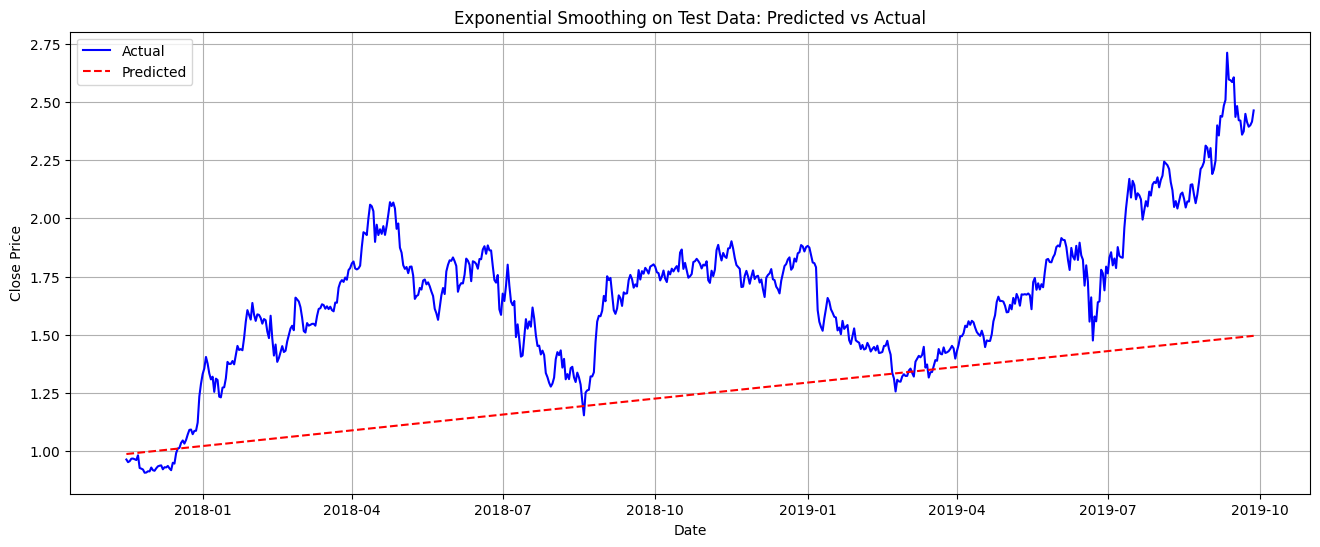

In [289]:
def exponential_smoothing_model(X_train, y_train, X_test, y_test):
    # Ensure the date index has a frequency
    y_train.index = pd.date_range(start=X_train.index[0], periods=len(X_train), freq=pd.infer_freq(X_train.index))
    y_test.index = pd.date_range(start=X_test.index[0], periods=len(X_test), freq=pd.infer_freq(X_test.index))

    # Fit the model
    model = ExponentialSmoothing(y_train, trend='add', seasonal=None, seasonal_periods=None)
    model_fit = model.fit()

    # Make predictions
    predictions = model_fit.forecast(steps=len(y_test))

    # Evaluate and plot
    print("\nExponential Smoothing Evaluation:")
    evaluate_model(y_test, predictions)
    plot_predictions(y_test, predictions, "Exponential Smoothing")

# Apply models
exponential_smoothing_model(X_train, y_train, X_test, y_test)

### ARIMA

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



ARIMA Evaluation:
Mean Squared Error: 0.2530
Mean Absolute Error: 0.4348
R^2 Score: -1.4898


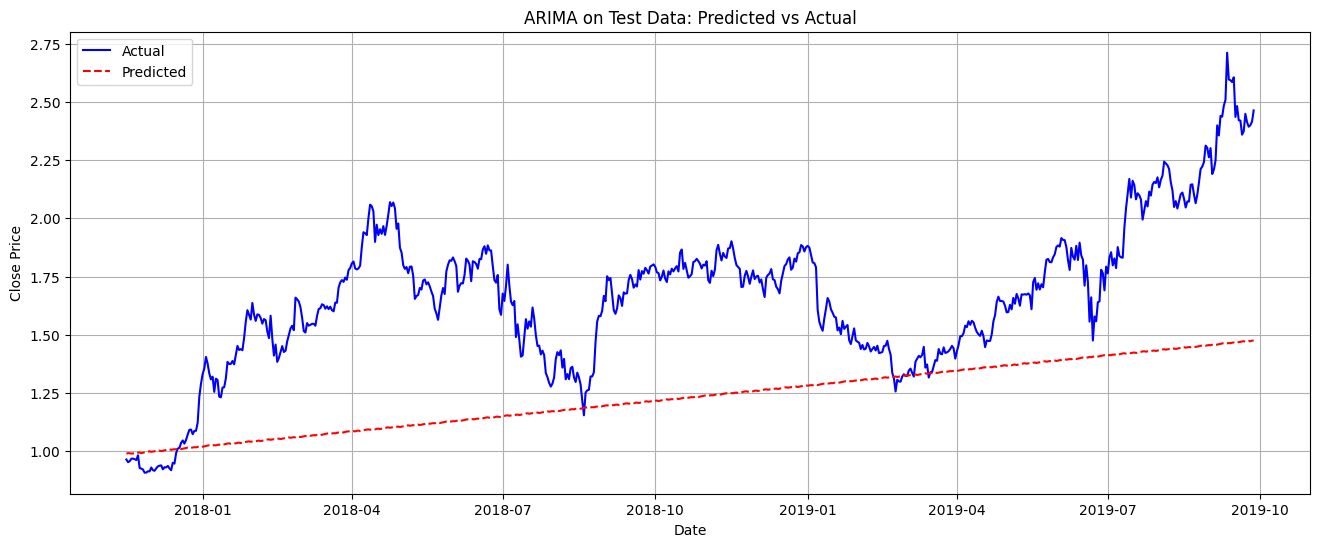

In [290]:
def arima_model(X_train, y_train, X_test, y_test):
    # Ensure the date index has a frequency
    y_train.index = pd.date_range(start=X_train.index[0], periods=len(X_train), freq=pd.infer_freq(X_train.index))
    y_test.index = pd.date_range(start=X_test.index[0], periods=len(X_test), freq=pd.infer_freq(X_test.index))

    # Fit the model
    model = ARIMA(y_train, order=(5, 1, 0), seasonal_order=(1, 1, 1, 12))
    model_fit = model.fit()

    # Make predictions
    predictions = model_fit.forecast(steps=len(y_test))

    # Evaluate and plot
    print("\nARIMA Evaluation:")
    evaluate_model(y_test, predictions)
    plot_predictions(y_test, predictions, "ARIMA")

# Apply models
arima_model(X_train, y_train, X_test, y_test)

### SARIMA

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



SARIMA Evaluation:
Mean Squared Error: 0.2530
Mean Absolute Error: 0.4348
R^2 Score: -1.4898


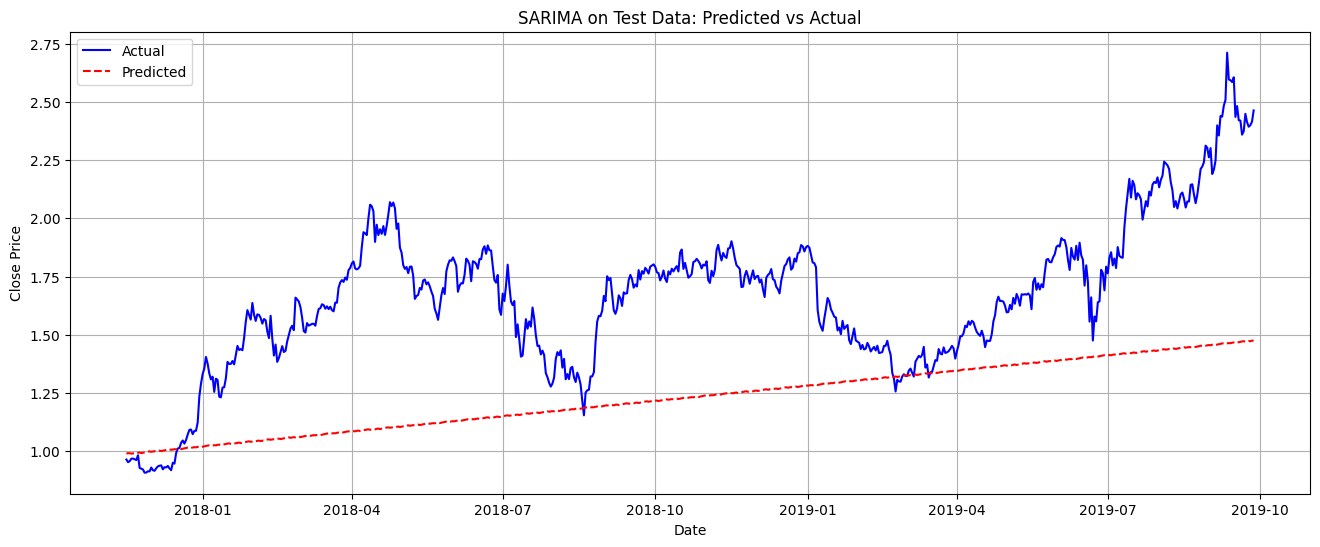

In [291]:
def sarima_model(X_train, y_train, X_test, y_test):
    # Ensure the date index has a frequency
    y_train.index = pd.date_range(start=X_train.index[0], periods=len(X_train), freq=pd.infer_freq(X_train.index))
    y_test.index = pd.date_range(start=X_test.index[0], periods=len(X_test), freq=pd.infer_freq(X_test.index))

    # Fit the model
    model = SARIMAX(y_train, order=(5, 1, 0), seasonal_order=(1, 1, 1, 12))  # Example seasonal order
    model_fit = model.fit()

    # Make predictions
    predictions = model_fit.forecast(steps=len(y_test))

    # Evaluate and plot
    print("\nSARIMA Evaluation:")
    evaluate_model(y_test, predictions)
    plot_predictions(y_test, predictions, "SARIMA")

# Apply the model
sarima_model(X_train, y_train, X_test, y_test)

### Neural Network: LSTM (Long Short-Time Memory)

In [292]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [293]:
# Convert DataFrames to NumPy arrays
X_train_np = X_train.values
X_test_np = X_test.values
y_train_np = y_train.values
y_test_np = y_test.values

# Reshape the arrays
X_train = X_train_np.reshape((-1, lookback, 1))
X_test = X_test_np.reshape((-1, lookback, 1))
y_train = y_train_np.reshape((-1, 1))
y_test = y_test_np.reshape((-1, 1))

# Check the shapes
X_train_np.shape, X_test_np.shape, y_train_np.shape, y_test_np.shape

((3886, 7), (681, 7), (3886,), (681,))

In [294]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([3886, 7, 1]),
 torch.Size([681, 7, 1]),
 torch.Size([3886, 1]),
 torch.Size([681, 1]))

In [295]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [296]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [297]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(input_size=1, hidden_size=64, num_stacked_layers=2)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [298]:
def train_one_epoch(epoch):
    model.train()
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        output = model(x_batch)
        loss = loss_function(output, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch + 1}, Training Loss: {running_loss / len(train_loader):.4f}")

In [299]:
def validate_one_epoch():
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for batch_index, batch in enumerate(test_loader):
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    print(f"Validation Loss: {running_loss / len(test_loader):.4f}")

In [300]:
learning_rate = 0.001
num_epochs = 20
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch(epoch)
    validate_one_epoch()

Epoch 1, Training Loss: 0.0163
Validation Loss: 0.1002
Epoch 2, Training Loss: 0.0002
Validation Loss: 0.1582
Epoch 3, Training Loss: 0.0002
Validation Loss: 0.1580
Epoch 4, Training Loss: 0.0002
Validation Loss: 0.1491
Epoch 5, Training Loss: 0.0002
Validation Loss: 0.1433
Epoch 6, Training Loss: 0.0002
Validation Loss: 0.1282
Epoch 7, Training Loss: 0.0002
Validation Loss: 0.1137
Epoch 8, Training Loss: 0.0002
Validation Loss: 0.1220
Epoch 9, Training Loss: 0.0002
Validation Loss: 0.1129
Epoch 10, Training Loss: 0.0002
Validation Loss: 0.1059
Epoch 11, Training Loss: 0.0002
Validation Loss: 0.1370
Epoch 12, Training Loss: 0.0002
Validation Loss: 0.0980
Epoch 13, Training Loss: 0.0002
Validation Loss: 0.1218
Epoch 14, Training Loss: 0.0002
Validation Loss: 0.1050
Epoch 15, Training Loss: 0.0002
Validation Loss: 0.0911
Epoch 16, Training Loss: 0.0001
Validation Loss: 0.1047
Epoch 17, Training Loss: 0.0002
Validation Loss: 0.0941
Epoch 18, Training Loss: 0.0002
Validation Loss: 0.0960
E

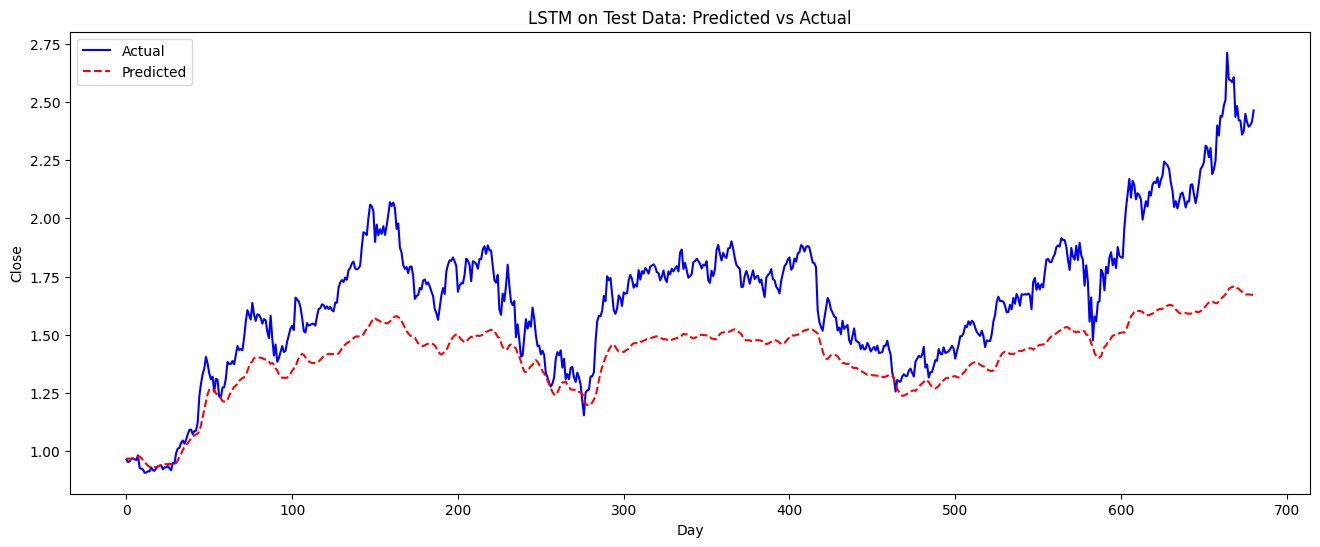

In [301]:
with torch.no_grad():
    predicted = model(X_test.to(device)).to('cpu').numpy()

plt.figure(figsize=(16, 6))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(predicted, label='Predicted', color='red', linestyle='--')
plt.xlabel('Day')
plt.ylabel('Close')
plt.title('LSTM on Test Data: Predicted vs Actual')
plt.legend()
plt.show()

In [302]:
evaluate_model(y_test, predicted)

Mean Squared Error: 0.0938
Mean Absolute Error: 0.2522
R^2 Score: 0.0773


(0.09377186, 0.25219634, 0.07729130983352661)